In [45]:
import numpy as np
import pandas as pd
import gensim
import spacy
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import os
import sys
import glob

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svenkata\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\svenkata\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',None) # to view the whole width of the cells in a dataframe

In [2]:
websites_txt = 'C:/Users/svenkata/Documents/websites_txt/'
a_txt = 'C:/Users/svenkata/Documents/a_txt/'

*Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration*

*Many times, the minority classes are treated as outliers*

In [188]:
stop = stopwords.words('english')

exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [189]:
def clean(doc):
    stop_free = ' '.join([i for i in doc if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalised = ''.join(lemma.lemmatize(word) for word in punc_free)
    
    return normalised

In [144]:
##I know this is very unprofessional but, string manipulation is very difficult otherwise!!
def replace_chars(path):
    to_replace = ['\\\\','\\']
    string=''
    for ch in path:
        if ch in to_replace:
            ch = '/'
        elif ch == '\v':
            ch = '/v'
        elif ch == '\b':
            ch = '/b'
        elif ch == '\t':
            ch = '/t'
        elif ch == '\a':
            ch = '/a'
        elif ch == '\f':
            ch = '/f'
        elif ch == '\n':
            ch = '/n'
        elif ch == '\r':
            ch = '\r'
        elif ch == '\h':
            ch = '/h'
        elif ch == '\o':
            ch = '/o'
        string = string+ch
    return string

In [190]:
import funcy as fp
## Something quick and dirty......
EMAIL_REGEX = re.compile(r'[a-z0-9\.\+_-]+@[a-z0-9\.\+_-]+\.[a-z]*')
FILTER_REGEX = re.compile(r"[^a-z '#]")
TOKEN_MAPPINGS = [(EMAIL_REGEX,"#email"),(FILTER_REGEX,' ')]

def tokenize_line(line):
    res = line.lower()
    for regexp, replacement in TOKEN_MAPPINGS:
        res = regexp.sub(replacement,res)
    return res.split()

def tokenize(lines, token_size_filter = 2):
    tokens = fp.mapcat(tokenize_line,lines)
    return [t for t in tokens if len(t) > token_size_filter]
   

def load_doc(folder_path):
    doc_list =[]
    for subdir, dirnames, files  in os.walk(folder_path):         
        for filename in files:             
            if (filename.split('.')[-1] =='txt'):
                #print(filename)
                filepath = subdir+os.sep+filename
                documentname = replace_chars(filepath)
                try:
                    with open(filepath, encoding='UTF-8', errors='ignore') as f:
                        doc = f.readlines()                          
                        tokens = tokenize(doc)
                        tokens = clean(tokens)
                        
                        
                    doc_list.append({'documentname': documentname, 'tokens':tokens  })
                except :
                    print(filepath)
            else:
                continue     
             
    doc_df = pd.DataFrame(doc_list)
    
    return doc_df



In [191]:
docs_websites = load_doc(websites_txt)

C:/Users/svenkata/Documents/websites_txt/Webteam\blogs\images from bloggers\Martin Willis blog pics\In reviewing the correspondence it is clear that the substance of your complaint regarding the wall boards is a continuation of the issues raised in your previous complaints.txt
C:/Users/svenkata/Documents/websites_txt/Webteam\Editorial\FOI request files 2016-12-12\Payments to he Advisory Panel on Public Sector Information [APPSI] and the Advisory Council on National Records and Archives [ACNRA] to the Confederation of British Industry and its subsidiaries.txt


In [192]:
docs_websites.head()

,documentname,tokens
0,C:/Users/svenkata/Documents/websites_txt/Angel...,sheet archives sector pages broken links octob...
1,C:/Users/svenkata/Documents/websites_txt/Angel...,sheet cake contributors yes kind cake vegan gl...
2,C:/Users/svenkata/Documents/websites_txt/Angel...,https media nationalarchives gov index php yea...
3,C:/Users/svenkata/Documents/websites_txt/Angel...,blog front end https blog nationalarchives gov...
4,C:/Users/svenkata/Documents/websites_txt/Angel...,https media nationalarchives gov index php col...


In [193]:
# Consists of contents of websites files as tokens for developing NLP models
docs_websites.to_pickle('H:/AI_for_Selection/websites_contents_NLP.pkl') # 

In [194]:
docs_a = load_doc(a_txt)
docs_a.to_pickle('H:/AI_for_Selection/a_contents_NLP.pkl')

C:/Users/svenkata/Documents/a_txt/20032008fp\RMDaILUa\C_3\DfID\A_3\PRAaD\AISU note of decisions from meeting with Middle East Centre and British Empire and Commonwealth Museum forwarded to DFID for confirmation that proposed solution is acceptable[A121439.1].txt
C:/Users/svenkata/Documents/a_txt/ASD\Cio\RSE\PHC0042\PHCIoSLO2015\Portsmouth Library and Archive Service - Inspection of Southsea Outstore 24th February 2015  - Advisory Letter   25th January 2016 - Postponing appointment pending accreditation[A4185929.1].txt
C:/Users/svenkata/Documents/a_txt/ASD\CS\AtA\AtApm\CaIPODPaICO\DIGITAL MEETS CULTURE - source for digital copyright contacts_activities_ RE_ published Fwd_ _AN INVITATION_ UKAD Forum - Thursday 27 March 2014, The National Archives [UNCLASSIFIED][A3529985.1].txt
C:/Users/svenkata/Documents/a_txt/ASD\Rwgan\Gb\NLHFHLF\CC_7\Collecting Cultures - response to request for second meeting - separate strand for discussing archive purchasing behaviour_ RE_ Next Collecting Cultures w

# Model Building

**Read Preprocessed Data into Data frame**

In [3]:
docs_a_df = pd.read_pickle('H:/AI_for_Selection/a_contents_NLP.pkl')# This file consists of the contents of the files (structured data from Objective)

In [4]:
a_meta_df = pd.read_pickle('H:/AI_for_Selection/metadata_with_filesize_lastmodified.pkl') # This file consists of processed metadata of structured data

txt_extensions = ['pdf','rtf','txt','msg','doc','docx','xls', 'xlsx','mbx']

a_meta_df=a_meta_df[a_meta_df.fileextension.isin(txt_extensions)]
a_meta_df = a_meta_df[['fileextension', 'disposal_schedule', 'repository','file_path' ,'ret_schedule','file_size']].copy()

In [5]:
websites_meta_df = pd.read_pickle('H:/AI_for_Selection/Websites_processed.pkl')# This file consists of metadata of processed websites data

In [6]:
docs_websites = pd.read_pickle('H:/AI_for_Selection/websites_contents_NLP.pkl') # This file consists of the contents of the files (unstructred X-drive data)
                    

In [7]:
docs_websites.head(1)

,documentname,tokens
0,C:/Users/svenkata/Documents/websites_txt/Angel...,sheet archives sector pages broken links octob...


**Merge contents file with metadata file on the target column (retention schedule)**

In [9]:
print(docs_a_df[:1]['documentname'])

0    C:/Users/svenkata/Documents/a_txt/20032008fp/Am/Cs/Es/L_5/LNAS/MDR 1 How to use the paper MDR[A905701.3].txt
Name: documentname, dtype: object


In [10]:
##function to extract file's absolute path and filename with no extension
def extract_absolutePath_removeExtension(topfolderpath, filename):
    filename = filename.replace(topfolderpath,'')
    words = filename.split('.')
    return '.'.join(words[:-1])

In [11]:
docs_a_df['abs_filepath'] = docs_a_df['documentname'].apply(lambda x: extract_absolutePath_removeExtension('C:/Users/svenkata/Documents/a_txt/',x))

In [12]:
print(docs_a_df[:1])

                                                                                                   documentname  \
0  C:/Users/svenkata/Documents/a_txt/20032008fp/Am/Cs/Es/L_5/LNAS/MDR 1 How to use the paper MDR[A905701.3].txt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [13]:
# check how the file path is represented in structured file
print(a_meta_df[:1])

  fileextension                                           disposal_schedule  \
0           xls  24 Projects - Full Projects (Close file when Project ends)   

           repository  \
0  Strategic Projects   

                                                                                          file_path  \
0  PPDaCM/PD/PC_1/20YRaCS/GE_1/2012RTR/RTRS2012DS/The National Archives RTR 09-2012[A3109716.2].xls   

  ret_schedule  file_size  
0           24     225280  


In [14]:
a_meta_df['abs_filepath']  = a_meta_df['file_path'].apply(lambda x: extract_absolutePath_removeExtension('', x))

In [15]:
print(a_meta_df[:1])

  fileextension                                           disposal_schedule  \
0           xls  24 Projects - Full Projects (Close file when Project ends)   

           repository  \
0  Strategic Projects   

                                                                                          file_path  \
0  PPDaCM/PD/PC_1/20YRaCS/GE_1/2012RTR/RTRS2012DS/The National Archives RTR 09-2012[A3109716.2].xls   

  ret_schedule  file_size  \
0           24     225280   

                                                                                   abs_filepath  
0  PPDaCM/PD/PC_1/20YRaCS/GE_1/2012RTR/RTRS2012DS/The National Archives RTR 09-2012[A3109716.2]  


**Merge doc contents with metadata on abs_filepath**

In [16]:
X = pd.merge(docs_a_df, a_meta_df, on='abs_filepath')

In [17]:
print(X.columns)

Index(['documentname', 'tokens', 'abs_filepath', 'fileextension',
       'disposal_schedule', 'repository', 'file_path', 'ret_schedule',
       'file_size'],
      dtype='object')


In [18]:
X.to_pickle('H:/AI_for_Selection/a_cleaned_ready_for_NLP.pkl')

**add a numerical category_id to avoid string type ret_schedule**

In [19]:
X['category_id'] = X['ret_schedule'].factorize()[0]
category_id_df = X[['disposal_schedule','category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id','disposal_schedule']].values)
X[:1]

,documentname,tokens,abs_filepath,fileextension,disposal_schedule,repository,file_path,ret_schedule,file_size,category_id
0,C:/Users/svenkata/Documents/a_txt/20032008fp/Am/Cs/Es/L_5/LNAS/MDR 1 How to use the paper MDR[A905701.3].txt,mdr use manorial documents register mdr manorial documents register mdr mdr index manorial records provides brief descriptions documents details locations mdr mainly paper index details counties wales three ridings yorkshire hampshire isle wight norfolk surrey middlesex revised updated computerised searched online www mdr nationalarchives gov mdr see nra non computerised counties use paper indexes mdr paper indexes mdr held research enquiries room divided two parts parish index manor index parish index parish index identifies names manors associated parishes two always identical arranged county alphabetically parish name within county information contained slip parish name middle slip manor name located top right hand corner manors may known variety names records listed one name manor index slip two manor names top right hand corner name preceded see standard manor name may one slip associated parish giving several manor names research possible parish index may include reference manor records indexed manor index indicates manor existed records survived location remains unknown please aware parish include one manors manors cross parish boundaries parts manors exist separately main body manor different parishes counties manor name known manor index consulted manor index manor index arranged county alphabetically manor name within county manor index contain reference manors known existed records extant manor may mentioned index information contained slip manor name top right hand corner document description date middle slip details location document reference found bottom please aware details locations may date repository names may changed pro tna kent archive office centre kentish studies information contained reverse slip reverse slip often provides source details document overleaf see reference number beginning nra catalogue collection held research enquiries room users mdr researching particular topographical area may find helpful consult nra list may contain references records although strictly manorial nature therefore included mdr may nevertheless prove useful research information nra see nra reference annual return means information came tna accessions repositories survey see nra information accessions pages reference means mdr team information file regarding location records information please contact mdr team every document noted mdr available research always check relevant repository first making visit view document slip refers private owner please apply writing information terms conditions access,20032008fp/Am/Cs/Es/L_5/LNAS/MDR 1 How to use the paper MDR[A905701.3],doc,33 Time Category Permanent,Historical Manuscripts Commission,20032008fp/Am/Cs/Es/L_5/LNAS/MDR 1 How to use the paper MDR[A905701.3].doc,33,225792,0


In [20]:
print('Length of X:',len(X))
# just checking
print(X.category_id.value_counts())
print(X.ret_schedule.value_counts())

Length of X: 93824
7     18741
11    13110
0     10786
6      8973
12     8047
1      7100
10     5115
4      2762
14     2713
3      2686
13     2679
9      2573
5      2298
8      1909
2      1612
18     1486
15      925
16      250
17       58
19        1
Name: category_id, dtype: int64
24     18741
02     13110
33     10786
05      8973
04      8047
23      7100
03      5115
20      2762
11      2713
21      2686
07      2679
27      2573
32      2298
28      1909
16      1612
24b     1486
10       925
25       250
06        58
24a        1
Name: ret_schedule, dtype: int64


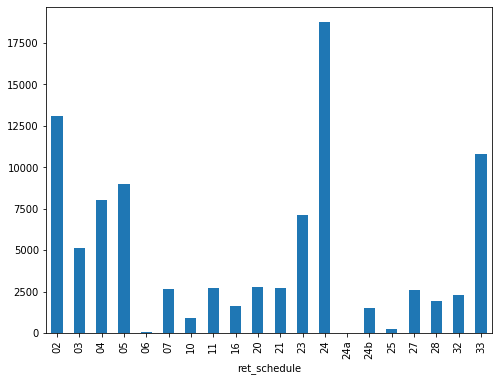

In [21]:
fig = plt.figure(figsize=(8,6))
X.groupby('ret_schedule').tokens.count().plot.bar(ylim=0)
plt.show()

# Working with Text docs

**Naive Bayes**

In [58]:
#just finding all those classes less than the average
zz = pd.DataFrame(list(zip(X.ret_schedule.value_counts().index.tolist(),X.ret_schedule.value_counts()) ),columns=['ret_sc', 'value'] )

In [59]:
zz ypred_2

,ret_sc,value
0,24,18741
1,02,13110
2,33,10786
3,05,8973
4,04,8047
5,23,7100
6,03,5115
7,20,2762
8,11,2713
9,21,2686


**The classes are highly unbalanced. Upsampling classes to an average**

In [63]:
from sklearn.utils import resample

In [64]:
avg = round(sum(X.ret_schedule.value_counts())/X.ret_schedule.nunique()) #4691
x_less_than_avg = zz[zz['value']<avg].ret_sc # list them
X_more_than_avg = zz[zz['value']>=avg].ret_sc


In [67]:
X_balanced = pd.DataFrame(columns=X.columns)
#Up sampling minority classes
for ret_sc in x_less_than_avg:
    df = X[X.ret_schedule == ret_sc]
    df = resample(df, 
                  replace=True,     # sample with replacement
                  n_samples=avg,    # to match majority class
                  random_state=123) # reproducible results
 
    #Combine majority class with upsampled minority class
    X_balanced = pd.concat([X_balanced, df])

#down sampling majority classes
for ret_sc in X_more_than_avg:
    df = X[X.ret_schedule == ret_sc]
    df = resample(df, 
                  #replace=True,     # sample with replacement
                  n_samples=avg,    # to match majority class
                  random_state=123) # reproducible results
 
    #Combine majority class with upsampled minority class
    X_balanced = pd.concat([X_balanced, df])    

In [68]:
X_balanced.ret_schedule.value_counts()

05     4691
16     4691
24     4691
07     4691
10     4691
32     4691
23     4691
06     4691
21     4691
27     4691
25     4691
03     4691
04     4691
02     4691
11     4691
33     4691
20     4691
28     4691
24b    4691
24a    4691
Name: ret_schedule, dtype: int64

In [69]:
X1 = X_balanced.tokens
y = X_balanced.ret_schedule


X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size = 0.3, random_state=42)

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer


In [72]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [76]:
%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))

Wall time: 0 ns
accuracy 0.8174163291409081
              precision    recall  f1-score   support

          02       0.70      0.66      0.68      1427
          03       0.88      0.89      0.88      1390
          04       0.92      0.81      0.86      1386
          05       0.91      0.66      0.77      1400
          06       0.91      1.00      0.95      1414
          07       0.64      0.86      0.73      1367
          10       0.85      0.78      0.81      1431
          11       0.63      0.74      0.68      1379
          16       0.99      0.97      0.98      1506
          20       0.85      0.73      0.79      1402
          21       0.64      0.86      0.74      1382
          23       0.94      0.68      0.79      1400
          24       0.97      0.61      0.75      1388
         24a       0.99      1.00      0.99      1399
         24b       0.90      0.98      0.94      1439
          25       0.92      0.92      0.92      1397
          27       0.94      0.79    

In [77]:
cm =confusion_matrix(y_test, y_pred)
pd.set_option('display.max_colwidth', None)
labels = np.unique(y_test)
df = pd.DataFrame(cm, index=labels, columns=labels)
print(df.to_string())

      02    03    04   05    06    07    10    11    16    20    21   23   24   24a   24b    25    27   28    32    33
02   942    80    11    0     4    64     3    16    10     2    98    2    0     0     2     8     6    0   105    74
03    12  1235    31    4     0     0     0     5     0     0     8    8    0     0     2     1     0    0    82     2
04    26    78  1128    0     0     0     0     0     0     1    27   12    0     0     1     1     0    4   103     5
05    46     3    20  924    64    55    17    26     3     5    65    2    3     0    11    19     9    1    88    39
06     0     0     0    0  1414     0     0     0     0     0     0    0    0     0     0     0     0    0     0     0
07    11     0     1   23     1  1181     8    14     0     9    35    0    1     0     4     5     4    1    55    14
10     6     0     1    9     0   106  1120    49     4    28    36    3    5     0     0     2     9    2    15    36
11    51     0     2    9     4    36    24  102

**Linear Support Vector Machine**

In [74]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier(loss= 'hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
              ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))

Wall time: 0 ns
accuracy 0.8379521068713138
              precision    recall  f1-score   support

          02       0.77      0.62      0.69      1427
          03       0.81      0.93      0.87      1390
          04       0.91      0.85      0.88      1386
          05       0.84      0.71      0.77      1400
          06       0.88      1.00      0.93      1414
          07       0.78      0.81      0.80      1367
          10       0.88      0.83      0.85      1431
          11       0.64      0.83      0.72      1379
          16       0.94      0.98      0.96      1506
          20       0.84      0.84      0.84      1402
          21       0.84      0.77      0.81      1382
          23       0.88      0.81      0.84      1400
          24       0.90      0.70      0.79      1388
         24a       0.99      1.00      1.00      1399
         24b       0.91      0.99      0.95      1439
          25       0.81      0.92      0.86      1397
          27       0.82      0.85    

In [75]:
cm =confusion_matrix(y_test, y_pred)
pd.set_option('display.max_colwidth', None)
labels = np.unique(y_test)
df = pd.DataFrame(cm, index=labels, columns=labels)
print(df.to_string())

      02    03    04   05    06    07    10    11    16    20    21    23   24   24a   24b    25    27    28    32    33
02   890   102    11   14    15    40    13    21    53    11    54     4   10     0     5    37    16    13    71    47
03     0  1295    37    3     0     0     0     3     0     1     1     7    0     1     2     1     3     2    31     3
04     3    80  1176    1     3     1     0     3     0     3    15     6    1     0     4    10     3     6    67     4
05    15    22    13  998    71    33    13    36     2    11    14    11    9     1    12    25    27    29    44    14
06     0     0     0    0  1414     0     0     0     0     0     0     0    0     0     0     0     0     0     0     0
07     9     8     2   40    11  1108    13    18     2     6    12    11    2     0     3    45    13    19    28    17
10     3     2     4   29     2    31  1186    51     0    22     4     0   18     0     0    14    35    13     6    11
11    13     3     2   13     8 

**Logistic Regression**

In [83]:
from sklearn.linear_model import LogisticRegression

lr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
lr.fit(X_train, y_train)

%time

y_pred = lr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Wall time: 0 ns
accuracy 0.9399559440062532
              precision    recall  f1-score   support

          02       0.88      0.82      0.85      1427
          03       0.92      0.95      0.93      1390
          04       0.97      0.97      0.97      1386
          05       0.95      0.90      0.92      1400
          06       1.00      1.00      1.00      1414
          07       0.96      0.95      0.96      1367
          10       0.98      0.97      0.97      1431
          11       0.71      0.96      0.81      1379
          16       1.00      1.00      1.00      1506
          20       0.96      0.94      0.95      1402
          21       0.95      0.94      0.94      1382
          23       0.93      0.95      0.94      1400
          24       0.94      0.89      0.91      1388
         24a       1.00      1.00      1.00      1399
         24b       0.99      1.00      0.99      1439
          25       1.00      0.92      0.95      1397
          27       0.96      0.94    

In [84]:
cm =confusion_matrix(y_test, y_pred)
pd.set_option('display.max_colwidth', None)
labels = np.unique(y_test)
df = pd.DataFrame(cm, index=labels, columns=labels)
print(df.to_string())

       02    03    04    05    06    07    10    11    16    20    21    23    24   24a   24b    25    27    28    32    33
02   1169    86     7    11     0    14     0    21     2     4    17    10     8     0     2     0     2     8    26    40
03     43  1317    16     2     0     0     0     1     0     0     0     1     1     0     0     0     2     0     7     0
04      7    10  1340     0     0     0     0     1     0     1     5     0     2     0     0     0     0     0    19     1
05     16     8     2  1260     0     9     6    21     1     8     4     8    17     0     0     1    11     3    14    11
06      0     0     0     0  1414     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
07     11     0     3     8     0  1301     2    13     0     3     4    12     1     0     0     1     1     3     3     1
10      0     0     0     0     0     1  1383    41     0     0     0     1     0     0     0     0     1     0     0     4
11      

**RandomForest Classification**

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier()),
                 ])
rf.fit(X_train, y_train)

%time

y_pred = rf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
ypred_2 = rf.predict_proba(X)
ypred_2 = [p[1] for p in ypred_2]
print( 'auc_roc_score %s' % roc_auc_score(y_test, ypred_2) )
print('Classification Report')
print(classification_report(y_test, y_pred))

Wall time: 0 ns
accuracy 0.9252824557663611


ValueError: multi_class must be in ('ovo', 'ovr')

In [86]:
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

          02       0.79      0.78      0.78      1427
          03       0.91      0.95      0.93      1390
          04       0.99      0.94      0.96      1386
          05       0.92      0.89      0.91      1400
          06       1.00      1.00      1.00      1414
          07       0.93      0.95      0.94      1367
          10       0.98      0.97      0.97      1431
          11       0.71      0.96      0.82      1379
          16       0.99      0.99      0.99      1506
          20       0.96      0.94      0.95      1402
          21       0.94      0.92      0.93      1382
          23       0.91      0.90      0.91      1400
          24       0.95      0.80      0.87      1388
         24a       1.00      1.00      1.00      1399
         24b       0.99      0.99      0.99      1439
          25       1.00      0.92      0.96      1397
          27       0.94      0.94      0.94      1398
     

In [87]:
cm =confusion_matrix(y_test, y_pred)
pd.set_option('display.max_colwidth', None)
labels = np.unique(y_test)
df = pd.DataFrame(cm, index=labels, columns=labels)
print(df.to_string())

       02    03    04    05    06    07    10    11    16    20    21    23    24   24a   24b    25    27    28    32    33
02   1108    87     3    18     0    22     0    16     1     4    19    11     7     0     1     0     7     6    29    88
03     35  1325     8     2     0     0     0     1     0     0     0     2     4     0     0     0     1     0     9     3
04     13    27  1297     1     0     0     0     0     0     2     2     4     0     0     0     0     1     0    29    10
05     20     0     0  1249     0    14     4    18     4     2     6    10     5     0     2     1    15     6    15    29
06      0     0     0     0  1414     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0
07     10     0     1     4     0  1292     0    14     1     3     5    12     4     0     0     0     5     3     6     7
10      5     0     0     0     0     0  1384    41     0     1     0     0     0     0     0     0     0     0     0     0
11      